# Pytorch CNN

A convolutional neural network written in pytorch.

## Imports

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
depth = 1 # Number of colors in the image (greyscale)

# Training Parameters
num_steps = 2000 # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Stochastic Gradient Descent batch size

# CNN Parameters
kernel_size = 5 # Convolutional Kernel size
kernel_depth = 32 # Convolutional Kernel depth size == Number of Convolutional Kernels
num_hidden = 1024 # Number of hidden neurons in the fully connected layer

# Optimization parameters
learning_rate = 0.0001 # Learning rate

# Cuda
cuda = True # use GPU or not

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = torch.tensor(np.int64(data[:,0]))
    labels_onehot = torch.tensor(np.zeros((len(labels), num_labels)))
    labels_onehot[torch.arange(len(labels)),labels] = 1
    values = torch.tensor(np.float32(data[:,1:]).reshape(-1, depth, height, width)/255)
    if cuda:
        return values.cuda(), labels.cuda(), labels_onehot.cuda()
    return value, labels, labels_onehot
    
train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		torch.Size([50000, 1, 28, 28])
train labels (one-hot) shape:	torch.Size([50000, 10])


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

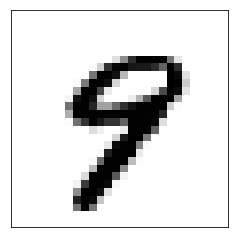

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.view(height, width).data.cpu().numpy(), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers. We use the `torch.nn.Module` to create the network.

We choose a 4 layered network consisting of 2 convolutional layers with kernel size `kernel_size` and depth `kernel_depth` and `2*kernel_depth` respectively. These convolutional layers are followed by two fully connected layers with `num_hidden` hidden neurons `num_labels` output nodes (one-hot encoding).

In [5]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        # First Convoluational Layer
        self.conv1 = torch.nn.Conv2d(
            in_channels=depth,
            out_channels=kernel_depth,
            kernel_size=kernel_size,
            stride=1,
            padding=(kernel_size-1)//2, # = 'SAME'
        )
        # Second Convolutional Layer
        self.conv2 = torch.nn.Conv2d(
            in_channels=kernel_depth,
            out_channels=2*kernel_depth,
            kernel_size=kernel_size,
            stride=1,
            padding=(kernel_size-1)//2, # = 'SAME'
        )
        # First Fully Connected Layer
        self.fc1 = torch.nn.Linear(
            in_features=width//4*width//4*2*kernel_depth,
            out_features=num_hidden,
        )
        # Second Fully Connected Layer
        self.fc2 = torch.nn.Linear(
            in_features=num_hidden,
            out_features=num_labels
        )
        # Max Pooling Layer
        self.mp = torch.nn.MaxPool2d(2)
        # ReLU Activateion Layer
        self.relu = torch.nn.ReLU()
        # Softmax Activation Layer
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, data):
        # first convolutional layer:
        x = self.relu(self.mp(self.conv1(data)))
        # second convolutional layer:
        x = self.relu(self.mp(self.conv2(x)))
        # first fully connected layer:
        x = self.relu(self.fc1(x.view(x.size(0),-1)))
        # second fully connected layer:
        logits = self.fc2(x)
        prediction = self.softmax(logits)
        return logits, prediction
    
model = Model()
if cuda:
    model = model.cuda()

We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp

In [6]:
# loss
lossfunc = torch.nn.CrossEntropyLoss()

# accuracy
def accuracy(prediction, labels):
    return 100*np.mean(np.argmax(prediction.data.cpu().numpy(), 1) == labels.data.cpu().numpy())

# optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

# Train

Run the session

In [7]:
%%time
history = [] 

for step in range(num_steps):
    # reset gradients
    optimizer.zero_grad()

    # calculate validation accuracy
    if step%(train_size//batch_size) == 0 or step == num_steps - 1:
        valid_logits, valid_prediction = model(valid_values)
        # get element of 0D array:
        valid_loss = lossfunc(valid_logits, valid_labels).item()
        valid_accuracy = accuracy(valid_prediction, valid_labels)
        history.append((step, valid_loss, valid_accuracy))
        print(f'Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}')
        # clear GPU memory
        del valid_logits, valid_prediction, valid_loss, valid_accuracy
    
    # train
    idxs = np.random.randint(0, train_size, batch_size)
    batch_values = train_values[idxs]
    batch_labels = train_labels[idxs]
    logits, prediction = model(batch_values)
    loss = lossfunc(logits, batch_labels)
    loss.backward()
    optimizer.step()
        
    # clear GPU memory
    del loss, logits, prediction, idxs, batch_labels, batch_values

Step     0	 Valid. Acc. =  9.18
Step   500	 Valid. Acc. = 96.52
Step  1000	 Valid. Acc. = 97.72
Step  1500	 Valid. Acc. = 98.18
Step  1999	 Valid. Acc. = 98.48
CPU times: user 11 s, sys: 3.71 s, total: 14.7 s
Wall time: 14.7 s


Training history:

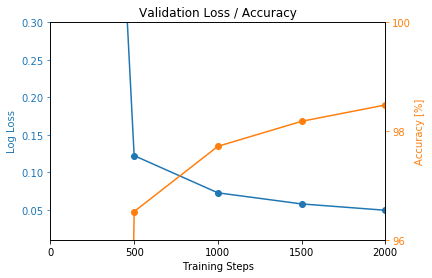

In [8]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(96,100)
plt.yticks([96,98,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 0.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

# Test

Finally, the accuracy on the test set can be evaluated:

In [9]:
_, test_prediction = model(test_values)
test_accuracy = accuracy(test_prediction, test_labels)
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 98.56


Visualize an example

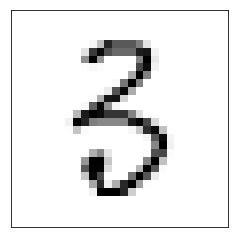

prediction=3	target=3


In [10]:
N = 315
show_digit(test_values[N])
_, prediction_onehot = model(test_values[N:N+1])
prediction = np.argmax(prediction_onehot.data.cpu().numpy().ravel())
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')